In [1]:
import torch
import scene
from scene import Scene
import os
from tqdm import tqdm
from os import makedirs
from gaussian_renderer import render
import torchvision
from utils.general_utils import safe_state
from argparse import ArgumentParser
from arguments import ModelParams, PipelineParams, get_combined_args
from gaussian_renderer import GaussianModel

In [2]:
import numpy as np
import collections
import struct

CameraModel = collections.namedtuple(
    "CameraModel", ["model_id", "model_name", "num_params"])
Camera = collections.namedtuple(
    "Camera", ["id", "model", "width", "height", "params"])
BaseImage = collections.namedtuple(
    "Image", ["id", "qvec", "tvec", "camera_id", "name", "xys", "point3D_ids"])
Point3D = collections.namedtuple(
    "Point3D", ["id", "xyz", "rgb", "error", "image_ids", "point2D_idxs"])
CAMERA_MODELS = {
    CameraModel(model_id=0, model_name="SIMPLE_PINHOLE", num_params=3),
    CameraModel(model_id=1, model_name="PINHOLE", num_params=4),
    CameraModel(model_id=2, model_name="SIMPLE_RADIAL", num_params=4),
    CameraModel(model_id=3, model_name="RADIAL", num_params=5),
    CameraModel(model_id=4, model_name="OPENCV", num_params=8),
    CameraModel(model_id=5, model_name="OPENCV_FISHEYE", num_params=8),
    CameraModel(model_id=6, model_name="FULL_OPENCV", num_params=12),
    CameraModel(model_id=7, model_name="FOV", num_params=5),
    CameraModel(model_id=8, model_name="SIMPLE_RADIAL_FISHEYE", num_params=4),
    CameraModel(model_id=9, model_name="RADIAL_FISHEYE", num_params=5),
    CameraModel(model_id=10, model_name="THIN_PRISM_FISHEYE", num_params=12)
}
CAMERA_MODEL_IDS = dict([(camera_model.model_id, camera_model)
                         for camera_model in CAMERA_MODELS])
CAMERA_MODEL_NAMES = dict([(camera_model.model_name, camera_model)
                           for camera_model in CAMERA_MODELS])


In [3]:
def qvec2rotmat(qvec):
    return np.array([
        [1 - 2 * qvec[2]**2 - 2 * qvec[3]**2,
         2 * qvec[1] * qvec[2] - 2 * qvec[0] * qvec[3],
         2 * qvec[3] * qvec[1] + 2 * qvec[0] * qvec[2]],
        [2 * qvec[1] * qvec[2] + 2 * qvec[0] * qvec[3],
         1 - 2 * qvec[1]**2 - 2 * qvec[3]**2,
         2 * qvec[2] * qvec[3] - 2 * qvec[0] * qvec[1]],
        [2 * qvec[3] * qvec[1] - 2 * qvec[0] * qvec[2],
         2 * qvec[2] * qvec[3] + 2 * qvec[0] * qvec[1],
         1 - 2 * qvec[1]**2 - 2 * qvec[2]**2]])

def rotmat2qvec(R):
    Rxx, Ryx, Rzx, Rxy, Ryy, Rzy, Rxz, Ryz, Rzz = R.flat
    K = np.array([
        [Rxx - Ryy - Rzz, 0, 0, 0],
        [Ryx + Rxy, Ryy - Rxx - Rzz, 0, 0],
        [Rzx + Rxz, Rzy + Ryz, Rzz - Rxx - Ryy, 0],
        [Ryz - Rzy, Rzx - Rxz, Rxy - Ryx, Rxx + Ryy + Rzz]]) / 3.0
    eigvals, eigvecs = np.linalg.eigh(K)
    qvec = eigvecs[[3, 0, 1, 2], np.argmax(eigvals)]
    if qvec[0] < 0:
        qvec *= -1
    return qvec

class Image(BaseImage):
    def qvec2rotmat(self):
        return qvec2rotmat(self.qvec)

def read_next_bytes(fid, num_bytes, format_char_sequence, endian_character="<"):
    """Read and unpack the next bytes from a binary file.
    :param fid:
    :param num_bytes: Sum of combination of {2, 4, 8}, e.g. 2, 6, 16, 30, etc.
    :param format_char_sequence: List of {c, e, f, d, h, H, i, I, l, L, q, Q}.
    :param endian_character: Any of {@, =, <, >, !}
    :return: Tuple of read and unpacked values.
    """
    data = fid.read(num_bytes)
    return struct.unpack(endian_character + format_char_sequence, data)

def read_points3D_text(path):
    """
    see: src/base/reconstruction.cc
        void Reconstruction::ReadPoints3DText(const std::string& path)
        void Reconstruction::WritePoints3DText(const std::string& path)
    """
    xyzs = None
    rgbs = None
    errors = None
    num_points = 0
    with open(path, "r") as fid:
        while True:
            line = fid.readline()
            if not line:
                break
            line = line.strip()
            if len(line) > 0 and line[0] != "#":
                num_points += 1


    xyzs = np.empty((num_points, 3))
    rgbs = np.empty((num_points, 3))
    errors = np.empty((num_points, 1))
    count = 0
    with open(path, "r") as fid:
        while True:
            line = fid.readline()
            if not line:
                break
            line = line.strip()
            if len(line) > 0 and line[0] != "#":
                elems = line.split()
                xyz = np.array(tuple(map(float, elems[1:4])))
                rgb = np.array(tuple(map(int, elems[4:7])))
                error = np.array(float(elems[7]))
                xyzs[count] = xyz
                rgbs[count] = rgb
                errors[count] = error
                count += 1

    return xyzs, rgbs, errors

def read_points3D_binary(path_to_model_file):
    """
    see: src/base/reconstruction.cc
        void Reconstruction::ReadPoints3DBinary(const std::string& path)
        void Reconstruction::WritePoints3DBinary(const std::string& path)
    """


    with open(path_to_model_file, "rb") as fid:
        num_points = read_next_bytes(fid, 8, "Q")[0]

        xyzs = np.empty((num_points, 3))
        rgbs = np.empty((num_points, 3))
        errors = np.empty((num_points, 1))

        for p_id in range(num_points):
            binary_point_line_properties = read_next_bytes(
                fid, num_bytes=43, format_char_sequence="QdddBBBd")
            xyz = np.array(binary_point_line_properties[1:4])
            rgb = np.array(binary_point_line_properties[4:7])
            error = np.array(binary_point_line_properties[7])
            track_length = read_next_bytes(
                fid, num_bytes=8, format_char_sequence="Q")[0]
            track_elems = read_next_bytes(
                fid, num_bytes=8*track_length,
                format_char_sequence="ii"*track_length)
            xyzs[p_id] = xyz
            rgbs[p_id] = rgb
            errors[p_id] = error
    return xyzs, rgbs, errors

def read_intrinsics_text(path):
    """
    Taken from https://github.com/colmap/colmap/blob/dev/scripts/python/read_write_model.py
    """
    cameras = {}
    with open(path, "r") as fid:
        while True:
            line = fid.readline()
            if not line:
                break
            line = line.strip()
            if len(line) > 0 and line[0] != "#":
                elems = line.split()
                camera_id = int(elems[0])
                model = elems[1]
                assert model == "PINHOLE", "While the loader support other types, the rest of the code assumes PINHOLE"
                width = int(elems[2])
                height = int(elems[3])
                params = np.array(tuple(map(float, elems[4:])))
                cameras[camera_id] = Camera(id=camera_id, model=model,
                                            width=width, height=height,
                                            params=params)
    return cameras

def read_extrinsics_binary(path_to_model_file):
    """
    see: src/base/reconstruction.cc
        void Reconstruction::ReadImagesBinary(const std::string& path)
        void Reconstruction::WriteImagesBinary(const std::string& path)
    """
    images = {}
    with open(path_to_model_file, "rb") as fid:
        num_reg_images = read_next_bytes(fid, 8, "Q")[0]
        for _ in range(num_reg_images):
            binary_image_properties = read_next_bytes(
                fid, num_bytes=64, format_char_sequence="idddddddi")
            image_id = binary_image_properties[0]
            qvec = np.array(binary_image_properties[1:5])
            tvec = np.array(binary_image_properties[5:8])
            camera_id = binary_image_properties[8]
            image_name = ""
            current_char = read_next_bytes(fid, 1, "c")[0]
            while current_char != b"\x00":   # look for the ASCII 0 entry
                image_name += current_char.decode("utf-8")
                current_char = read_next_bytes(fid, 1, "c")[0]
            num_points2D = read_next_bytes(fid, num_bytes=8,
                                           format_char_sequence="Q")[0]
            x_y_id_s = read_next_bytes(fid, num_bytes=24*num_points2D,
                                       format_char_sequence="ddq"*num_points2D)
            xys = np.column_stack([tuple(map(float, x_y_id_s[0::3])),
                                   tuple(map(float, x_y_id_s[1::3]))])
            point3D_ids = np.array(tuple(map(int, x_y_id_s[2::3])))
            images[image_id] = Image(
                id=image_id, qvec=qvec, tvec=tvec,
                camera_id=camera_id, name=image_name,
                xys=xys, point3D_ids=point3D_ids)
    return images


def read_intrinsics_binary(path_to_model_file):
    """
    see: src/base/reconstruction.cc
        void Reconstruction::WriteCamerasBinary(const std::string& path)
        void Reconstruction::ReadCamerasBinary(const std::string& path)
    """
    cameras = {}
    with open(path_to_model_file, "rb") as fid:
        num_cameras = read_next_bytes(fid, 8, "Q")[0]
        for _ in range(num_cameras):
            camera_properties = read_next_bytes(
                fid, num_bytes=24, format_char_sequence="iiQQ")
            camera_id = camera_properties[0]
            model_id = camera_properties[1]
            model_name = CAMERA_MODEL_IDS[camera_properties[1]].model_name
            width = camera_properties[2]
            height = camera_properties[3]
            num_params = CAMERA_MODEL_IDS[model_id].num_params
            params = read_next_bytes(fid, num_bytes=8*num_params,
                                     format_char_sequence="d"*num_params)
            cameras[camera_id] = Camera(id=camera_id,
                                        model=model_name,
                                        width=width,
                                        height=height,
                                        params=np.array(params))
        assert len(cameras) == num_cameras
    return cameras



In [4]:
# read_intrinsics_binary('./data/custom/plant/sparse/0/cameras.bin')
read_extrinsics_binary('./data/custom/plant/sparse/0/images.bin')
# read_points3D_binary('./data/custom/plant/sparse/0/points3D.bin')

{401: Image(id=401, qvec=array([ 0.99985851,  0.0016626 , -0.00805024, -0.01467635]), tvec=array([-0.5960359 , -1.03486182,  2.13041496]), camera_id=1, name='frame_00401.png', xys=array([[ 698.10713422,   42.50935492],
        [ 698.10713422,   42.50935492],
        [ 435.43408959,   47.88765658],
        ...,
        [ 702.36497831, 1200.73819015],
        [ 463.2942069 , 1292.0899213 ],
        [ 463.2942069 , 1292.0899213 ]]), point3D_ids=array([ 8731,  8730, 40126, ...,  3843, 27864,    -1])),
 400: Image(id=400, qvec=array([ 9.99855892e-01,  8.25002496e-04, -7.76379553e-03, -1.50743883e-02]), tvec=array([-0.59003271, -1.04276613,  2.15418347]), camera_id=1, name='frame_00400.png', xys=array([[ 972.11705475,   25.05779415],
        [ 696.38630006,   43.93036266],
        [ 698.91628699,   45.81256792],
        ...,
        [ 703.80136131, 1199.12266642],
        [ 464.5321099 , 1294.03974619],
        [ 464.5321099 , 1294.03974619]]), point3D_ids=array([   -1,    -1,  8731, ...,  3

In [5]:
read_intrinsics_binary('./data/gs_ref/db/drjohnson/sparse/0/cameras.bin')
read_extrinsics_binary('./data/gs_ref/db/drjohnson/sparse/0/images.bin')
# read_points3D_binary('./data/gs_ref/db/drjohnson/sparse/0/points3D.bin')

{1: Image(id=1, qvec=array([ 0.63441466, -0.60657111,  0.34485027, -0.33266774]), tvec=array([3.12442   , 0.18842234, 1.63034882]), camera_id=1, name='IMG_6292.jpg', xys=array([[ 8.86740934e+02, -1.25530589e-01],
        [ 1.00735824e+03, -9.51658939e-01],
        [ 1.02705938e+03, -7.02590496e-01],
        ...,
        [ 6.92806440e+02,  1.26105895e+02],
        [ 1.90654912e+02,  6.80234164e+02],
        [ 9.77091883e+02,  3.10035211e+02]]), point3D_ids=array([-1, -1, -1, ..., -1, -1, -1])),
 2: Image(id=2, qvec=array([ 0.62854091, -0.62162281,  0.33786403, -0.32306239]), tvec=array([ 3.16081977, -0.11868367,  1.59011308]), camera_id=1, name='IMG_6293.jpg', xys=array([[ 5.58431731e+02,  1.48113656e+00],
        [ 5.55996236e+02,  3.25670181e+00],
        [ 1.07757172e+03, -2.80764678e-02],
        ...,
        [ 6.57970537e+01,  7.49080819e+02],
        [ 1.39972637e+01,  3.06859016e+02],
        [ 7.01984652e+02,  4.30639467e+02]]), point3D_ids=array([-1, -1, -1, ..., -1, -1, -1])),

In [6]:
import os
import sys
from PIL import Image
from typing import NamedTuple
from scene.colmap_loader import read_extrinsics_text, read_intrinsics_text, qvec2rotmat, \
    read_extrinsics_binary, read_intrinsics_binary, read_points3D_binary, read_points3D_text
from utils.graphics_utils import getWorld2View2, focal2fov, fov2focal
import numpy as np
import json
from pathlib import Path
from plyfile import PlyData, PlyElement
from utils.sh_utils import SH2RGB
from scene.gaussian_model import BasicPointCloud

class CameraInfo(NamedTuple):
    uid: int
    R: np.array
    T: np.array
    FovY: np.array
    FovX: np.array
    image: np.array
    image_path: str
    image_name: str
    width: int
    height: int

class SceneInfo(NamedTuple):
    point_cloud: BasicPointCloud
    train_cameras: list
    test_cameras: list
    nerf_normalization: dict
    ply_path: str

def getNerfppNorm(cam_info):
    def get_center_and_diag(cam_centers):
        cam_centers = np.hstack(cam_centers)
        avg_cam_center = np.mean(cam_centers, axis=1, keepdims=True)
        center = avg_cam_center
        dist = np.linalg.norm(cam_centers - center, axis=0, keepdims=True)
        diagonal = np.max(dist)
        return center.flatten(), diagonal

    cam_centers = []

    for cam in cam_info:
        W2C = getWorld2View2(cam.R, cam.T)
        C2W = np.linalg.inv(W2C)
        cam_centers.append(C2W[:3, 3:4])

    center, diagonal = get_center_and_diag(cam_centers)
    radius = diagonal * 1.1

    translate = -center

    return {"translate": translate, "radius": radius}

def readColmapCameras(cam_extrinsics, cam_intrinsics, images_folder):
    cam_infos = []
    for idx, key in enumerate(cam_extrinsics):
        sys.stdout.write('\r')
        # the exact output you're looking for:
        sys.stdout.write("Reading camera {}/{}".format(idx+1, len(cam_extrinsics)))
        sys.stdout.flush()

        extr = cam_extrinsics[key]
        intr = cam_intrinsics[extr.camera_id] 
        height = intr.height
        width = intr.width


        uid = intr.id

        R = np.transpose(qvec2rotmat(extr.qvec))
        T = np.array(extr.tvec)

        if intr.model=="SIMPLE_PINHOLE":
            focal_length_x = intr.params[0]
            FovY = focal2fov(focal_length_x, height)
            FovX = focal2fov(focal_length_x, width)
        elif intr.model=="PINHOLE":
            focal_length_x = intr.params[0]
            focal_length_y = intr.params[1]
            FovY = focal2fov(focal_length_y, height)
            FovX = focal2fov(focal_length_x, width)
        else:
            assert False, "Colmap camera model not handled: only undistorted datasets (PINHOLE or SIMPLE_PINHOLE cameras) supported!"

        image_path = os.path.join(images_folder, os.path.basename(extr.name))
        image_name = os.path.basename(image_path).split(".")[0]
        image = Image.open(image_path)

        cam_info = CameraInfo(uid=uid, R=R, T=T, FovY=FovY, FovX=FovX, image=image,
                              image_path=image_path, image_name=image_name, width=width, height=height)
        cam_infos.append(cam_info)
    sys.stdout.write('\n')
    return cam_infos

def fetchPly(path):
    plydata = PlyData.read(path)
    vertices = plydata['vertex']
    positions = np.vstack([vertices['x'], vertices['y'], vertices['z']]).T
    colors = np.vstack([vertices['red'], vertices['green'], vertices['blue']]).T / 255.0
    normals = np.vstack([vertices['nx'], vertices['ny'], vertices['nz']]).T
    return BasicPointCloud(points=positions, colors=colors, normals=normals)

def storePly(path, xyz, rgb):
    # Define the dtype for the structured array
    dtype = [('x', 'f4'), ('y', 'f4'), ('z', 'f4'),
            ('nx', 'f4'), ('ny', 'f4'), ('nz', 'f4'),
            ('red', 'u1'), ('green', 'u1'), ('blue', 'u1')]
    
    normals = np.zeros_like(xyz)

    elements = np.empty(xyz.shape[0], dtype=dtype)
    attributes = np.concatenate((xyz, normals, rgb), axis=1)
    elements[:] = list(map(tuple, attributes))

    # Create the PlyData object and write to file
    vertex_element = PlyElement.describe(elements, 'vertex')
    ply_data = PlyData([vertex_element])
    ply_data.write(path)

def readColmapSceneInfo(path, images, eval, llffhold=8):
    try:
        cameras_extrinsic_file = os.path.join(path, "sparse/0", "images.bin")
        cameras_intrinsic_file = os.path.join(path, "sparse/0", "cameras.bin")
        cam_extrinsics = read_extrinsics_binary(cameras_extrinsic_file)
        cam_intrinsics = read_intrinsics_binary(cameras_intrinsic_file)
    except:
        cameras_extrinsic_file = os.path.join(path, "sparse/0", "images.txt")
        cameras_intrinsic_file = os.path.join(path, "sparse/0", "cameras.txt")
        cam_extrinsics = read_extrinsics_text(cameras_extrinsic_file)
        cam_intrinsics = read_intrinsics_text(cameras_intrinsic_file)

    reading_dir = "images" if images == None else images
    cam_infos_unsorted = readColmapCameras(cam_extrinsics=cam_extrinsics, cam_intrinsics=cam_intrinsics, images_folder=os.path.join(path, reading_dir))
    cam_infos = sorted(cam_infos_unsorted.copy(), key = lambda x : x.image_name)

    if eval:
        ## for using the last 5 images as test set 
        # train_cam_infos = cam_infos[:len(cam_infos)-5]
        # test_cam_infos = cam_infos[len(cam_infos)-5:]
        
        train_cam_infos = cam_infos[:170]
        test_cam_infos = cam_infos[170:]
        #############################
        # train_cam_infos = [c for idx, c in enumerate(cam_infos) if idx % llffhold != 0]
        # test_cam_infos = [c for idx, c in enumerate(cam_infos) if idx % llffhold == 0]
    else:
        train_cam_infos = cam_infos
        test_cam_infos = []

    nerf_normalization = getNerfppNorm(train_cam_infos)

    ply_path = os.path.join(path, "sparse/0/points3D.ply")
    bin_path = os.path.join(path, "sparse/0/points3D.bin")
    txt_path = os.path.join(path, "sparse/0/points3D.txt")
    if not os.path.exists(ply_path):
        print("Converting point3d.bin to .ply, will happen only the first time you open the scene.")
        try:
            xyz, rgb, _ = read_points3D_binary(bin_path)
        except:
            xyz, rgb, _ = read_points3D_text(txt_path)
        storePly(ply_path, xyz, rgb)
    try:
        pcd = fetchPly(ply_path)
    except:
        pcd = None

    scene_info = SceneInfo(point_cloud=pcd,
                           train_cameras=train_cam_infos,
                           test_cameras=test_cam_infos,
                           nerf_normalization=nerf_normalization,
                           ply_path=ply_path)
    return scene_info

def readCamerasFromTransforms(path, transformsfile, white_background, extension=".png"):
    cam_infos = []

    with open(os.path.join(path, transformsfile)) as json_file:
        contents = json.load(json_file)
        fovx = contents["camera_angle_x"]

        frames = contents["frames"]
        for idx, frame in enumerate(frames):
            cam_name = os.path.join(path, frame["file_path"] + extension)

            # NeRF 'transform_matrix' is a camera-to-world transform
            c2w = np.array(frame["transform_matrix"])
            # change from OpenGL/Blender camera axes (Y up, Z back) to COLMAP (Y down, Z forward)
            c2w[:3, 1:3] *= -1

            # get the world-to-camera transform and set R, T
            w2c = np.linalg.inv(c2w)
            R = np.transpose(w2c[:3,:3])  # R is stored transposed due to 'glm' in CUDA code
            T = w2c[:3, 3]

            image_path = os.path.join(path, cam_name)
            image_name = Path(cam_name).stem
            image = Image.open(image_path)

            im_data = np.array(image.convert("RGBA"))

            bg = np.array([1,1,1]) if white_background else np.array([0, 0, 0])

            norm_data = im_data / 255.0
            arr = norm_data[:,:,:3] * norm_data[:, :, 3:4] + bg * (1 - norm_data[:, :, 3:4])
            image = Image.fromarray(np.array(arr*255.0, dtype=np.byte), "RGB")

            fovy = focal2fov(fov2focal(fovx, image.size[0]), image.size[1])
            FovY = fovy 
            FovX = fovx

            cam_infos.append(CameraInfo(uid=idx, R=R, T=T, FovY=FovY, FovX=FovX, image=image,
                            image_path=image_path, image_name=image_name, width=image.size[0], height=image.size[1]))
            
    return cam_infos

def readNerfSyntheticInfo(path, white_background, eval, extension=".png"):
    print("Reading Training Transforms")
    train_cam_infos = readCamerasFromTransforms(path, "transforms_train.json", white_background, extension)
    print("Reading Test Transforms")
    test_cam_infos = readCamerasFromTransforms(path, "transforms_test.json", white_background, extension)
    
    if not eval:
        train_cam_infos.extend(test_cam_infos)
        test_cam_infos = []

    nerf_normalization = getNerfppNorm(train_cam_infos)

    ply_path = os.path.join(path, "points3d.ply")
    if not os.path.exists(ply_path):
        # Since this data set has no colmap data, we start with random points
        num_pts = 100_000
        print(f"Generating random point cloud ({num_pts})...")
        
        # We create random points inside the bounds of the synthetic Blender scenes
        xyz = np.random.random((num_pts, 3)) * 2.6 - 1.3
        shs = np.random.random((num_pts, 3)) / 255.0
        pcd = BasicPointCloud(points=xyz, colors=SH2RGB(shs), normals=np.zeros((num_pts, 3)))

        storePly(ply_path, xyz, SH2RGB(shs) * 255)
    try:
        pcd = fetchPly(ply_path)
    except:
        pcd = None

    scene_info = SceneInfo(point_cloud=pcd,
                           train_cameras=train_cam_infos,
                           test_cameras=test_cam_infos,
                           nerf_normalization=nerf_normalization,
                           ply_path=ply_path)
    return scene_info

sceneLoadTypeCallbacks = {
    "Colmap": readColmapSceneInfo,
    "Blender" : readNerfSyntheticInfo
}

In [7]:
cam_extrinsics = read_extrinsics_binary('./data/custom/work/sparse/0/images.bin')
cam_intrinsics = read_intrinsics_binary('./data/custom/work/sparse/0/cameras.bin')


In [8]:
readColmapCameras(cam_extrinsics=cam_extrinsics, cam_intrinsics=cam_intrinsics, images_folder='./data/custom/work/images')

Reading camera 258/258


[CameraInfo(uid=1, R=array([[ 0.95476482,  0.08590196,  0.28468402],
        [-0.07724649,  0.9961473 , -0.0415154 ],
        [-0.28715348,  0.0176466 ,  0.95772203]]), T=array([-0.66324668, -0.1843924 ,  0.074607  ]), FovY=0.6196963117792306, FovX=1.031333969603764, image=<PIL.PngImagePlugin.PngImageFile image mode=RGB size=1263x710 at 0x7E0C296ADC50>, image_path='./data/custom/work/images/frame_00258.png', image_name='frame_00258', width=1263, height=710),
 CameraInfo(uid=1, R=array([[ 0.85117309,  0.25093753, -0.46101489],
        [-0.31037483,  0.94893209, -0.05652751],
        [ 0.42328695,  0.19120211,  0.88559015]]), T=array([ 0.01620604, -0.44621601,  3.61066392]), FovY=0.6196963117792306, FovX=1.031333969603764, image=<PIL.PngImagePlugin.PngImageFile image mode=RGB size=1263x710 at 0x7E0C2969CB10>, image_path='./data/custom/work/images/frame_00126.png', image_name='frame_00126', width=1263, height=710),
 CameraInfo(uid=1, R=array([[ 0.83778495,  0.25869621, -0.48082496],
     

In [9]:
scene_info = readColmapSceneInfo('./data/custom/work', images=None, eval=True, llffhold=8)


Reading camera 258/258


In [10]:
scene_info.test_cameras

[CameraInfo(uid=1, R=array([[ 0.54460935,  0.44722768, -0.70949846],
        [-0.33031972,  0.89196353,  0.30869069],
        [ 0.77090177,  0.06624549,  0.6334998 ]]), T=array([ 0.29249024, -0.32565342,  0.20013635]), FovY=0.6196963117792306, FovX=1.031333969603764, image=<PIL.PngImagePlugin.PngImageFile image mode=RGB size=1263x710 at 0x7E0C282C0950>, image_path='./data/custom/work/images/frame_00171.png', image_name='frame_00171', width=1263, height=710),
 CameraInfo(uid=1, R=array([[ 0.55767562,  0.44182191, -0.70270286],
        [-0.32930923,  0.89486101,  0.30129587],
        [ 0.7619405 ,  0.06338117,  0.6445382 ]]), T=array([ 0.28849601, -0.3275199 ,  0.20329513]), FovY=0.6196963117792306, FovX=1.031333969603764, image=<PIL.PngImagePlugin.PngImageFile image mode=RGB size=1263x710 at 0x7E0C282C0A10>, image_path='./data/custom/work/images/frame_00172.png', image_name='frame_00172', width=1263, height=710),
 CameraInfo(uid=1, R=array([[ 0.57522602,  0.43474904, -0.69289847],
     

In [11]:
cam_intrinsics1 = read_intrinsics_binary('./data/custom/work/sparse/0/cameras.bin')
cam_extrinsics1 = read_extrinsics_binary('./data/custom/work/sparse/0/images.bin')
readColmapCameras(cam_extrinsics=cam_extrinsics1, cam_intrinsics=cam_intrinsics1, images_folder='./data/custom/plant/images')

Reading camera 258/258


[CameraInfo(uid=1, R=array([[ 0.95476482,  0.08590196,  0.28468402],
        [-0.07724649,  0.9961473 , -0.0415154 ],
        [-0.28715348,  0.0176466 ,  0.95772203]]), T=array([-0.66324668, -0.1843924 ,  0.074607  ]), FovY=0.6196963117792306, FovX=1.031333969603764, image=<PIL.PngImagePlugin.PngImageFile image mode=RGB size=1080x1920 at 0x7E0C280E8F50>, image_path='./data/custom/plant/images/frame_00258.png', image_name='frame_00258', width=1263, height=710),
 CameraInfo(uid=1, R=array([[ 0.85117309,  0.25093753, -0.46101489],
        [-0.31037483,  0.94893209, -0.05652751],
        [ 0.42328695,  0.19120211,  0.88559015]]), T=array([ 0.01620604, -0.44621601,  3.61066392]), FovY=0.6196963117792306, FovX=1.031333969603764, image=<PIL.PngImagePlugin.PngImageFile image mode=RGB size=1080x1920 at 0x7E0C280E8D50>, image_path='./data/custom/plant/images/frame_00126.png', image_name='frame_00126', width=1263, height=710),
 CameraInfo(uid=1, R=array([[ 0.83778495,  0.25869621, -0.48082496],
 

In [12]:
scene_info_test = readColmapSceneInfo('./data/custom/work', images=None, eval=True, llffhold=8)

Reading camera 258/258


In [13]:
scene_info_test.test_cameras

[CameraInfo(uid=1, R=array([[ 0.54460935,  0.44722768, -0.70949846],
        [-0.33031972,  0.89196353,  0.30869069],
        [ 0.77090177,  0.06624549,  0.6334998 ]]), T=array([ 0.29249024, -0.32565342,  0.20013635]), FovY=0.6196963117792306, FovX=1.031333969603764, image=<PIL.PngImagePlugin.PngImageFile image mode=RGB size=1263x710 at 0x7E0C280BC4D0>, image_path='./data/custom/work/images/frame_00171.png', image_name='frame_00171', width=1263, height=710),
 CameraInfo(uid=1, R=array([[ 0.55767562,  0.44182191, -0.70270286],
        [-0.32930923,  0.89486101,  0.30129587],
        [ 0.7619405 ,  0.06338117,  0.6445382 ]]), T=array([ 0.28849601, -0.3275199 ,  0.20329513]), FovY=0.6196963117792306, FovX=1.031333969603764, image=<PIL.PngImagePlugin.PngImageFile image mode=RGB size=1263x710 at 0x7E0C280BC590>, image_path='./data/custom/work/images/frame_00172.png', image_name='frame_00172', width=1263, height=710),
 CameraInfo(uid=1, R=array([[ 0.57522602,  0.43474904, -0.69289847],
     

In [14]:
# finding the distance between two cameras 

def quaternion_distance(q1, q2):
    # Calculate the angular distance between two quaternions
    dot_product = np.dot(q1, q2)
    return 1 - abs(dot_product)

def camera_distance(cam1, cam2, alpha=1.0, beta=1.0, gamma=1.0, delta=1.0):

    q1 = rotmat2qvec(cam1.R)
    q2 = rotmat2qvec(cam2.R)

    translation_distance = np.linalg.norm(cam1.T - cam2.T)
    rotation_distance = quaternion_distance(q1, q2)
    fovX_distance = abs(cam1.FovX - cam2.FovX)
    fovY_distance = abs(cam1.FovY - cam2.FovY)
    
    total_distance = (alpha * translation_distance + 
                      beta * rotation_distance + 
                      gamma * fovX_distance + 
                      delta * fovY_distance)
    
    return total_distance

In [15]:
def calculate_distances(train_cameras, test_cameras):
    distances = []
    for train_cam in train_cameras:
        min_distance = float('inf')
        for test_cam in test_cameras:
            distance = camera_distance(train_cam, test_cam)
            if distance < min_distance:
                min_distance = distance
        distances.append(min_distance)
    return distances

In [16]:
camera_distance(scene_info_test.train_cameras[0], scene_info_test.train_cameras[40])

1.1770701645264683

In [17]:
camera_distance(scene_info_test.train_cameras[130], scene_info_test.test_cameras[0])

3.4272987078425956

In [18]:
distances = calculate_distances(scene_info_test.train_cameras, scene_info_test.test_cameras)

In [19]:
max_distance = max(distances)
probabilities = [(max_distance - d + 1e-5) for d in distances]
total = sum(probabilities)
probabilities = [p / total for p in probabilities]
print(probabilities)

[5.2939528747125696e-05, 4.638339320713336e-05, 3.275420464928069e-05, 5.269722115708632e-08, 7.615585602837446e-06, 2.0973300302714743e-05, 6.431959137750299e-05, 0.0001781396442267617, 0.0002661499507910053, 0.00035960980375727075, 0.0005234579053768905, 0.0006924858381588819, 0.000769577495652109, 0.0008054566503901678, 0.0008527224158908858, 0.000865666168527973, 0.0008953675576731381, 0.0011096131958892293, 0.001396405831327249, 0.0016957564882230489, 0.0019109401587986267, 0.0020762514607747767, 0.0022336830936340105, 0.002255696176068212, 0.0022915475958340745, 0.002436329686160921, 0.002635460941780414, 0.002767324700228476, 0.0027771934648189167, 0.0028096745665296225, 0.002838022206955784, 0.0026956890561825263, 0.0026165010250953006, 0.002670762872482722, 0.002801404606833398, 0.0029159287728447465, 0.002945561656763585, 0.0029080791281603535, 0.0027691578853054582, 0.0026857732510765435, 0.0027435714392745137, 0.002897962115685151, 0.0031682226294884558, 0.00336007873213031

In [20]:
from random import choices
viewpoint_stack = scene_info_test.train_cameras.copy()
viewpoint_cam = choices(viewpoint_stack, weights= probabilities,k=1)[0]
print(viewpoint_cam)

CameraInfo(uid=1, R=array([[ 0.97973948,  0.13184926,  0.15075255],
       [-0.0913844 ,  0.96410355, -0.2493055 ],
       [-0.17821182,  0.23047801,  0.95661927]]), T=array([ 0.30376095, -0.32195246,  3.71779899]), FovY=0.6196963117792306, FovX=1.031333969603764, image=<PIL.PngImagePlugin.PngImageFile image mode=RGB size=1263x710 at 0x7E0C2823D710>, image_path='./data/custom/work/images/frame_00106.png', image_name='frame_00106', width=1263, height=710)


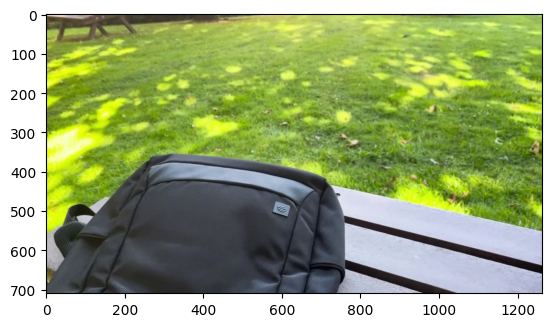

In [21]:
import matplotlib.pyplot as plt 
plt.imshow(scene_info_test.test_cameras[2].image)

In [22]:
view_test = [CameraInfo(uid=1, R=np.array([[ 0.01197063,  0.35942869, -0.93309577],
       [-0.36837951,  0.86911389,  0.33005693],
       [ 0.92959843,  0.33978237,  0.14281001]]), 
       T=np.array([ 0.22266113, -0.5297604 ,  3.94045344]), 
       FovY=np.array(0.6196963117792306), FovX=np.array(1.031333969603764), 
       image=None, image_path=None, image_name='test_custom', 
       width=1263, height=710)  ]

In [23]:
scene_info_test.train_cameras[0]

CameraInfo(uid=1, R=array([[-0.92091918,  0.15787924, -0.35634534],
       [-0.04122794,  0.86969411,  0.49186625],
       [ 0.38756692,  0.46766045, -0.79440895]]), T=array([ 0.78946567, -0.3083951 ,  4.7279736 ]), FovY=0.6196963117792306, FovX=1.031333969603764, image=<PIL.PngImagePlugin.PngImageFile image mode=RGB size=1263x710 at 0x7E0C2817E390>, image_path='./data/custom/work/images/frame_00001.png', image_name='frame_00001', width=1263, height=710)

In [24]:
camlist = [scene_info_test.train_cameras[0]]

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
def convert2df(cam_info):
    df = pd.DataFrame(columns=['img','translation','rotation'])
    for item in cam_info:
        df = df.append({'img': item.image_name, 'translation': item.T, 'rotation': item.R}, ignore_index=True)
    df['rotation'] = df['rotation'].apply(lambda x: x.flatten())
    df['tx'] = df['translation'].apply(lambda x: x[0]) 
    df['ty'] = df['translation'].apply(lambda x: x[1])
    df['tz'] = df['translation'].apply(lambda x: x[2])

    df['r11'] = df['rotation'].apply(lambda x: x[0])
    df['r12'] = df['rotation'].apply(lambda x: x[1])
    df['r13'] = df['rotation'].apply(lambda x: x[2])
    df['r21'] = df['rotation'].apply(lambda x: x[3])
    df['r22'] = df['rotation'].apply(lambda x: x[4])
    df['r23'] = df['rotation'].apply(lambda x: x[5])
    df['r31'] = df['rotation'].apply(lambda x: x[6])
    df['r32'] = df['rotation'].apply(lambda x: x[7])
    df['r33'] = df['rotation'].apply(lambda x: x[8])
    df.drop(['translation', 'rotation'], axis=1, inplace=True)
    return df

    

In [27]:
df_train = convert2df(scene_info_test.train_cameras)
df_test = convert2df(scene_info_test.test_cameras)

In [28]:
df_train

,img,tx,ty,tz,r11,r12,r13,r21,r22,r23,r31,r32,r33
0,frame_00001,0.789466,-0.308395,4.727974,-0.920919,0.157879,-0.356345,-0.041228,0.869694,0.491866,0.387567,0.467660,-0.794409
1,frame_00002,0.823900,-0.311073,4.722885,-0.923243,0.158026,-0.350214,-0.038004,0.869474,0.492515,0.382332,0.468020,-0.796730
2,frame_00003,0.864455,-0.316078,4.717421,-0.926052,0.158608,-0.342450,-0.033494,0.869279,0.493186,0.375908,0.468185,-0.799685
3,frame_00004,0.898757,-0.322044,4.715181,-0.929486,0.158942,-0.332855,-0.028119,0.869238,0.493593,0.367783,0.468147,-0.803476
4,frame_00005,0.911308,-0.328002,4.706850,-0.933638,0.159042,-0.320976,-0.021568,0.869453,0.493544,0.357568,0.467714,-0.808324
...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,frame_00166,0.592113,-0.451398,3.705345,-0.419425,0.312913,-0.852155,-0.293309,0.841653,0.453421,0.859100,0.440121,-0.261230
166,frame_00167,0.587851,-0.458833,3.704793,-0.456171,0.306220,-0.835546,-0.283511,0.839995,0.462634,0.843522,0.447927,-0.296365
167,frame_00168,0.577994,-0.450904,3.699600,-0.490754,0.299737,-0.818119,-0.273125,0.838719,0.471120,0.827383,0.454653,-0.329739
168,frame_00169,0.591975,-0.444334,3.663644,-0.524494,0.293080,-0.799381,-0.262469,0.837503,0.479269,0.809948,0.461187,-0.362341


<AxesSubplot:xlabel='r11', ylabel='r12'>

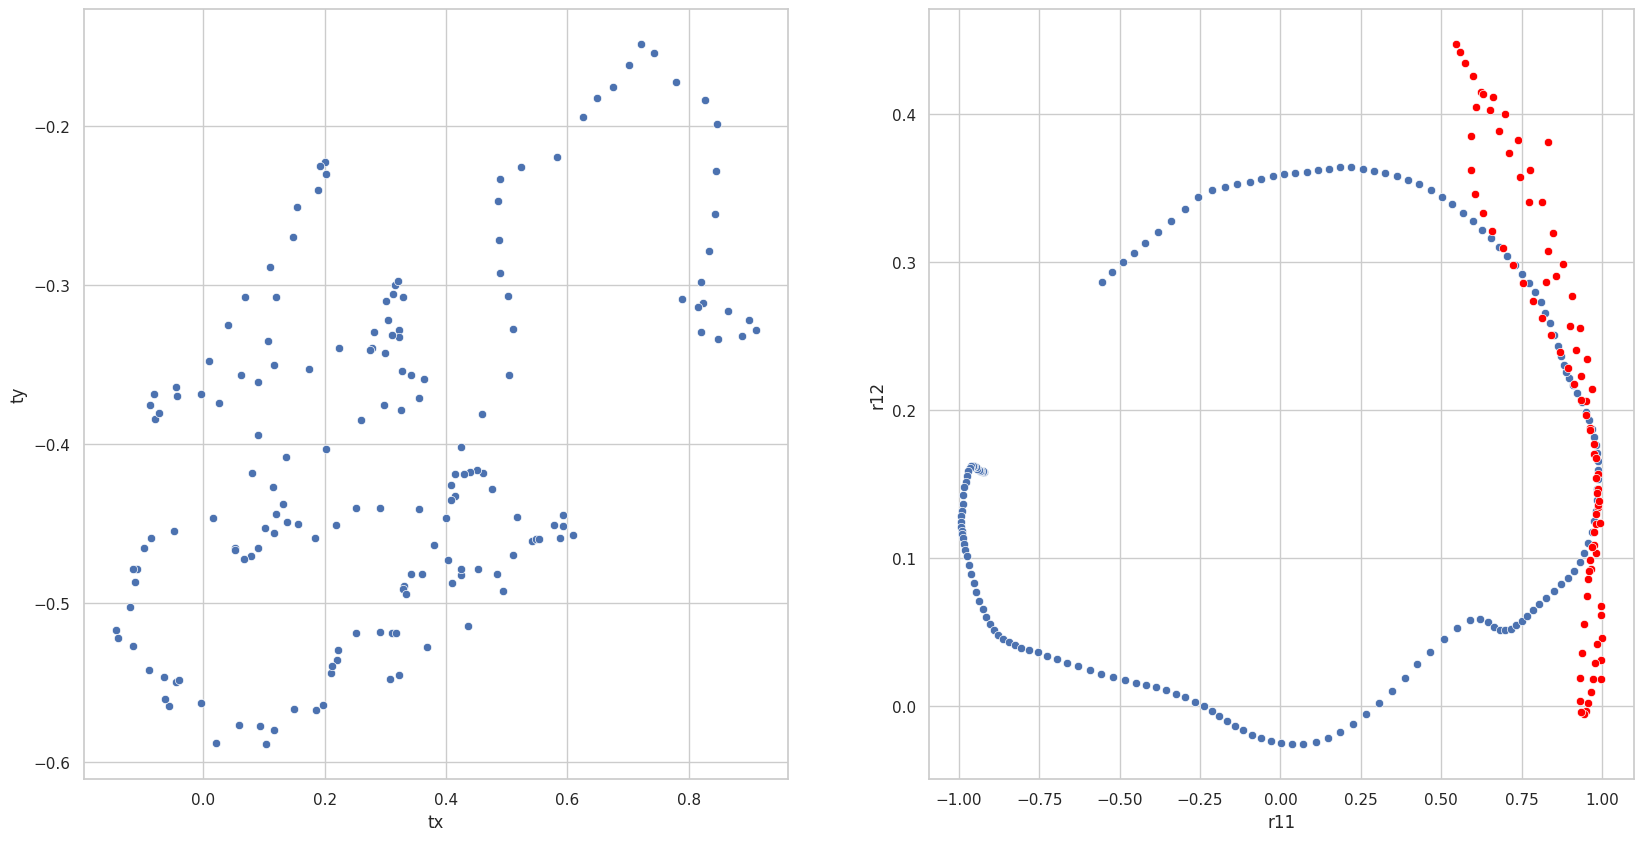

In [29]:
sns.set(style='whitegrid')
fig,ax = plt.subplots(1,2,figsize=(20,10))
sns.scatterplot(x='tx', y='ty', data=df_train, ax=ax[0])
sns.scatterplot(x='r11', y='r12', data=df_train, ax=ax[1])
sns.scatterplot(x='r11', y='r12', data=df_test, ax=ax[1], color='red')

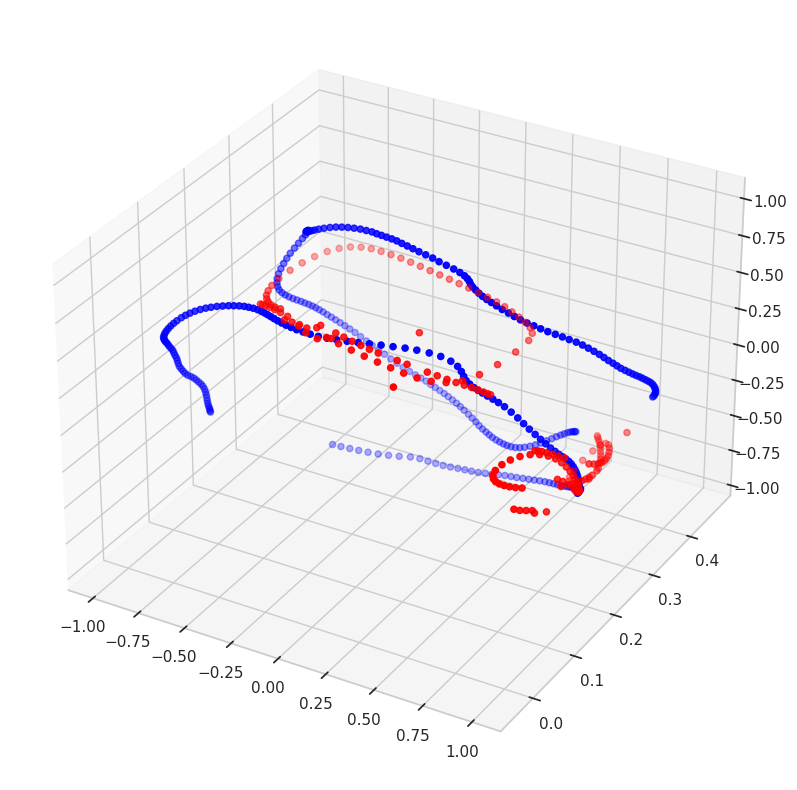

In [30]:
# plot in 3d r11, r12, r13 
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_train['r11'], df_train['r12'], df_train['r13'], c='blue', marker='o')
# ax.scatter(df_train['r21'], df_train['r22'], df_train['r23'], c='blue', marker='o')
ax.scatter(df_train['r31'], df_train['r32'], df_train['r33'], c='blue', marker='o')
ax.scatter(df_test['r11'], df_test['r12'], df_test['r13'], c='red', marker='o')
# ax.scatter(df_test['r21'], df_test['r22'], df_test['r23'], c='red', marker='o')
ax.scatter(df_test['r31'], df_test['r32'], df_test['r33'], c='red', marker='o')

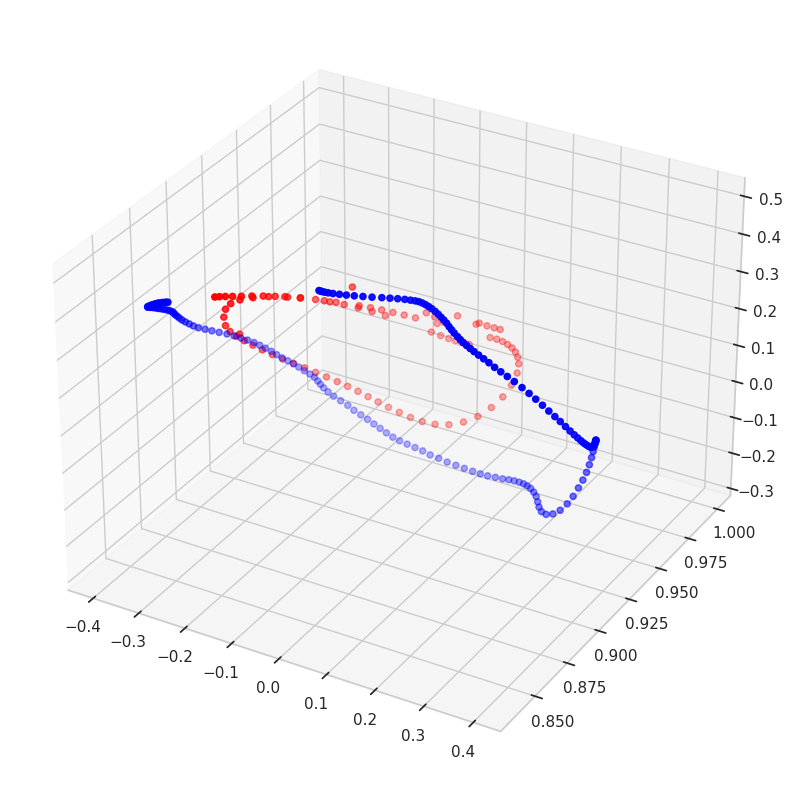

In [31]:
# plot in 3d r21, 22, r23  
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_train['r21'], df_train['r22'], df_train['r23'], c='blue', marker='o')
ax.scatter(df_test['r21'], df_test['r22'], df_test['r23'], c='red', marker='o')


In [32]:
gaze_info = pd.read_csv('gaze_results_attr.csv')
gaze_info['image_name'] = gaze_info['image_name'].apply(lambda x: x.split('.')[0])

In [33]:
gaze_info

,image_name,gaze_direction,head_position
0,frame_00001,"[40.0, 38.0]","[697.2, 314.5, 743.18, 368.95]"
1,frame_00002,"[40.0, 38.0]","[705.3, 314.6, 750.07, 367.84]"
2,frame_00003,"[42.0, 37.0]","[715.0, 312.3, 763.4, 369.17]"
3,frame_00004,"[43.0, 37.0]","[725.3, 315.9, 770.07, 365.51]"
4,frame_00005,"[43.0, 37.0]","[728.1, 310.5, 775.29, 364.95]"
...,...,...,...
130,frame_00166,"[44.0, 34.0]","[663.9, 268.7, 713.51, 344.93]"
131,frame_00167,"[61.0, 4.0]","[659.9, 264.7, 709.51, 340.93]"
132,frame_00168,"[61.0, 5.0]","[654.7, 262.2, 706.73, 344.48]"
133,frame_00169,"[41.0, 36.0]","[657.6, 266.5, 710.84, 345.15]"


In [34]:
# join gaze info with the camera info based on image name 
df_train_new = df_train.merge(gaze_info, left_on='img', right_on='image_name')

In [35]:
df_train_new

,img,tx,ty,tz,r11,r12,r13,r21,r22,r23,r31,r32,r33,image_name,gaze_direction,head_position
0,frame_00001,0.789466,-0.308395,4.727974,-0.920919,0.157879,-0.356345,-0.041228,0.869694,0.491866,0.387567,0.467660,-0.794409,frame_00001,"[40.0, 38.0]","[697.2, 314.5, 743.18, 368.95]"
1,frame_00002,0.823900,-0.311073,4.722885,-0.923243,0.158026,-0.350214,-0.038004,0.869474,0.492515,0.382332,0.468020,-0.796730,frame_00002,"[40.0, 38.0]","[705.3, 314.6, 750.07, 367.84]"
2,frame_00003,0.864455,-0.316078,4.717421,-0.926052,0.158608,-0.342450,-0.033494,0.869279,0.493186,0.375908,0.468185,-0.799685,frame_00003,"[42.0, 37.0]","[715.0, 312.3, 763.4, 369.17]"
3,frame_00004,0.898757,-0.322044,4.715181,-0.929486,0.158942,-0.332855,-0.028119,0.869238,0.493593,0.367783,0.468147,-0.803476,frame_00004,"[43.0, 37.0]","[725.3, 315.9, 770.07, 365.51]"
4,frame_00005,0.911308,-0.328002,4.706850,-0.933638,0.159042,-0.320976,-0.021568,0.869453,0.493544,0.357568,0.467714,-0.808324,frame_00005,"[43.0, 37.0]","[728.1, 310.5, 775.29, 364.95]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,frame_00166,0.592113,-0.451398,3.705345,-0.419425,0.312913,-0.852155,-0.293309,0.841653,0.453421,0.859100,0.440121,-0.261230,frame_00166,"[44.0, 34.0]","[663.9, 268.7, 713.51, 344.93]"
131,frame_00167,0.587851,-0.458833,3.704793,-0.456171,0.306220,-0.835546,-0.283511,0.839995,0.462634,0.843522,0.447927,-0.296365,frame_00167,"[61.0, 4.0]","[659.9, 264.7, 709.51, 340.93]"
132,frame_00168,0.577994,-0.450904,3.699600,-0.490754,0.299737,-0.818119,-0.273125,0.838719,0.471120,0.827383,0.454653,-0.329739,frame_00168,"[61.0, 5.0]","[654.7, 262.2, 706.73, 344.48]"
133,frame_00169,0.591975,-0.444334,3.663644,-0.524494,0.293080,-0.799381,-0.262469,0.837503,0.479269,0.809948,0.461187,-0.362341,frame_00169,"[41.0, 36.0]","[657.6, 266.5, 710.84, 345.15]"


In [36]:
df_test

,img,tx,ty,tz,r11,r12,r13,r21,r22,r23,r31,r32,r33
0,frame_00171,0.292490,-0.325653,0.200136,0.544609,0.447228,-0.709498,-0.330320,0.891964,0.308691,0.770902,0.066245,0.633500
1,frame_00172,0.288496,-0.327520,0.203295,0.557676,0.441822,-0.702703,-0.329309,0.894861,0.301296,0.761941,0.063381,0.644538
2,frame_00173,0.277954,-0.330672,0.209062,0.575226,0.434749,-0.692898,-0.328094,0.898570,0.291420,0.749313,0.059704,0.659520
3,frame_00174,0.258380,-0.331510,0.219448,0.598301,0.425814,-0.678763,-0.326676,0.903135,0.278620,0.731655,0.055037,0.679450
4,frame_00175,0.235130,-0.330451,0.233188,0.623916,0.415034,-0.662175,-0.323763,0.908460,0.264344,0.711271,0.049459,0.701175
...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,frame_00254,-0.605292,-0.201469,0.119379,0.975406,0.117743,0.186331,-0.114269,0.993017,-0.029313,-0.188481,0.007300,0.982050
84,frame_00255,-0.632745,-0.191772,0.100635,0.969337,0.107258,0.221094,-0.102043,0.994167,-0.034913,-0.223549,0.011281,0.974627
85,frame_00256,-0.649935,-0.185332,0.083109,0.963304,0.098420,0.249717,-0.091647,0.995042,-0.038636,-0.252282,0.014332,0.967548
86,frame_00257,-0.660601,-0.183950,0.081810,0.958399,0.091508,0.270365,-0.083527,0.995666,-0.040903,-0.272936,0.016619,0.961889


<AxesSubplot:xlabel='tx', ylabel='ty'>

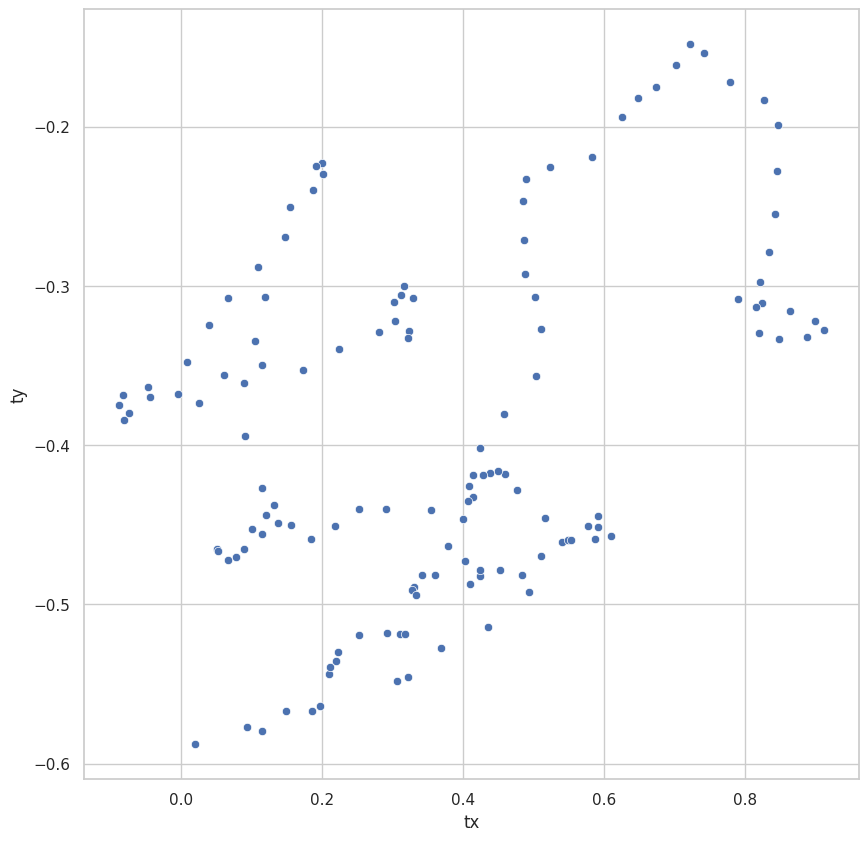

In [37]:
plt.figure(figsize=(10,10)) 
sns.scatterplot(x='tx', y='ty', data=df_train_new)

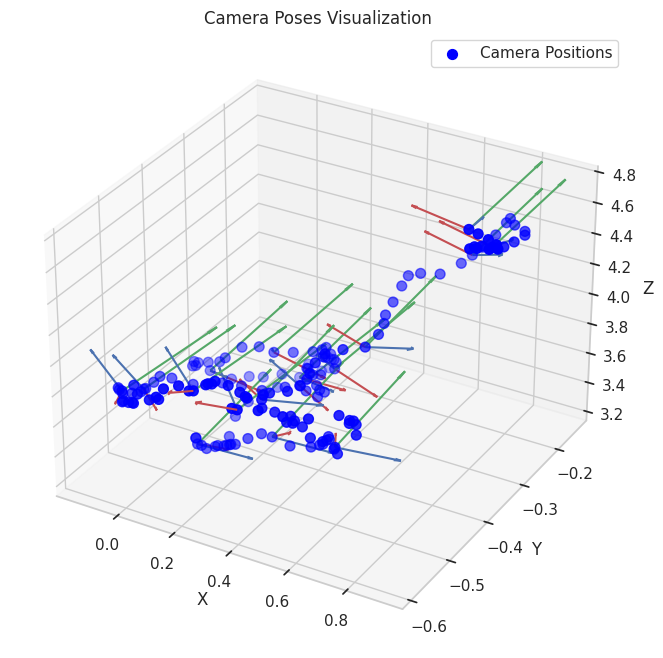

In [47]:
# Visualize the camera pose using the extrinsic and intrinsic parameters 
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_camera_poses(df):
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot camera positions
    ax.scatter(df['tx'], df['ty'], df['tz'], c='blue', marker='o', s=50, label='Camera Positions')
    
    count = 0
    # Plot camera orientations
    for _, row in df.iterrows():
        if count % 10 == 0:
    
            R = np.array([[row['r11'], row['r12'], row['r13']],
                        [row['r21'], row['r22'], row['r23']],
                        [row['r31'], row['r32'], row['r33']]])
            t = np.array([row['tx'], row['ty'], row['tz']])
            
            # Plot coordinate axes
            for i, c in enumerate(['r', 'g', 'b']):
                ax.quiver(t[0], t[1], t[2], 
                        R[0, i], R[1, i], R[2, i], 
                        length=0.2, color=c, arrow_length_ratio=0.1)
        count += 1

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Camera Poses Visualization')
    ax.legend()
    plt.show()


# Visualize camera poses for training data
plot_camera_poses(df_train)

# Visualize camera poses for test data
# plot_camera_poses(df_test)


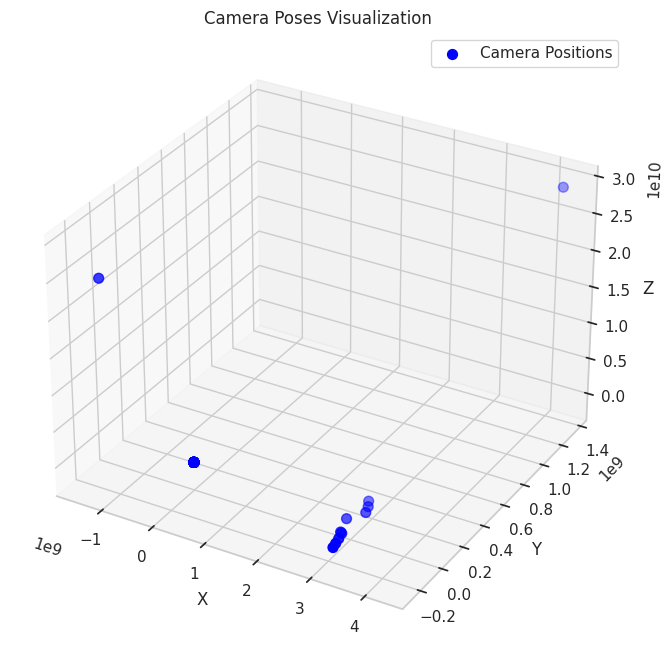

In [44]:
plot_camera_poses(df_test)

In [41]:
df_train

,img,tx,ty,tz,r11,r12,r13,r21,r22,r23,r31,r32,r33
0,frame_00001,0.789466,-0.308395,4.727974,-0.920919,0.157879,-0.356345,-0.041228,0.869694,0.491866,0.387567,0.467660,-0.794409
1,frame_00002,0.823900,-0.311073,4.722885,-0.923243,0.158026,-0.350214,-0.038004,0.869474,0.492515,0.382332,0.468020,-0.796730
2,frame_00003,0.864455,-0.316078,4.717421,-0.926052,0.158608,-0.342450,-0.033494,0.869279,0.493186,0.375908,0.468185,-0.799685
3,frame_00004,0.898757,-0.322044,4.715181,-0.929486,0.158942,-0.332855,-0.028119,0.869238,0.493593,0.367783,0.468147,-0.803476
4,frame_00005,0.911308,-0.328002,4.706850,-0.933638,0.159042,-0.320976,-0.021568,0.869453,0.493544,0.357568,0.467714,-0.808324
...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,frame_00166,0.592113,-0.451398,3.705345,-0.419425,0.312913,-0.852155,-0.293309,0.841653,0.453421,0.859100,0.440121,-0.261230
166,frame_00167,0.587851,-0.458833,3.704793,-0.456171,0.306220,-0.835546,-0.283511,0.839995,0.462634,0.843522,0.447927,-0.296365
167,frame_00168,0.577994,-0.450904,3.699600,-0.490754,0.299737,-0.818119,-0.273125,0.838719,0.471120,0.827383,0.454653,-0.329739
168,frame_00169,0.591975,-0.444334,3.663644,-0.524494,0.293080,-0.799381,-0.262469,0.837503,0.479269,0.809948,0.461187,-0.362341


In [42]:
df_test

,img,tx,ty,tz,r11,r12,r13,r21,r22,r23,r31,r32,r33
0,frame_00171,0.292490,-0.325653,0.200136,0.544609,0.447228,-0.709498,-0.330320,0.891964,0.308691,0.770902,0.066245,0.633500
1,frame_00172,0.288496,-0.327520,0.203295,0.557676,0.441822,-0.702703,-0.329309,0.894861,0.301296,0.761941,0.063381,0.644538
2,frame_00173,0.277954,-0.330672,0.209062,0.575226,0.434749,-0.692898,-0.328094,0.898570,0.291420,0.749313,0.059704,0.659520
3,frame_00174,0.258380,-0.331510,0.219448,0.598301,0.425814,-0.678763,-0.326676,0.903135,0.278620,0.731655,0.055037,0.679450
4,frame_00175,0.235130,-0.330451,0.233188,0.623916,0.415034,-0.662175,-0.323763,0.908460,0.264344,0.711271,0.049459,0.701175
...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,frame_00254,-0.605292,-0.201469,0.119379,0.975406,0.117743,0.186331,-0.114269,0.993017,-0.029313,-0.188481,0.007300,0.982050
84,frame_00255,-0.632745,-0.191772,0.100635,0.969337,0.107258,0.221094,-0.102043,0.994167,-0.034913,-0.223549,0.011281,0.974627
85,frame_00256,-0.649935,-0.185332,0.083109,0.963304,0.098420,0.249717,-0.091647,0.995042,-0.038636,-0.252282,0.014332,0.967548
86,frame_00257,-0.660601,-0.183950,0.081810,0.958399,0.091508,0.270365,-0.083527,0.995666,-0.040903,-0.272936,0.016619,0.961889


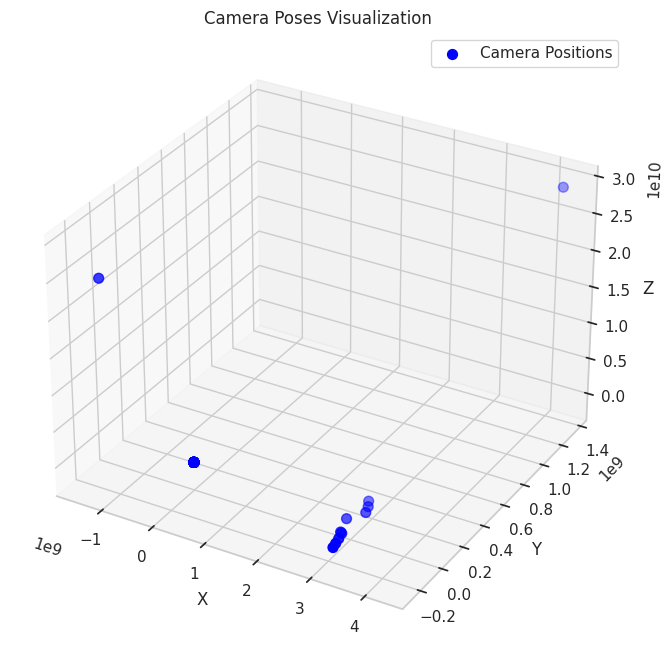

In [40]:
plot_camera_poses(df_test)

In [86]:
from utils.camera_utils import cameraList_from_camInfos, camera_to_JSON

json_cams = []  
for id, cam in enumerate(camlist):
    json_cams.append(camera_to_JSON(id, cam))

In [87]:
json_cams[0]

{'id': 0,
 'img_name': 'frame_00001',
 'width': 1263,
 'height': 710,
 'position': [2.4605146271591147, -2.0247732178597837, 3.5941979829372115],
 'rotation': [[-0.9209191839007738, 0.15787924214051138, -0.35634534039982985],
  [-0.04122794013758118, 0.8696941097515786, 0.4918662546012088],
  [0.387566915094084, 0.46766045413798557, -0.7944089538517979]],
 'fy': 1108.8202834456206,
 'fx': 1114.105310510803}

In [88]:

views = [
    CameraInfo(uid=1, R=np.array([[ 0.01197063,  0.35942869, -0.93309577],
       [-0.36837951,  0.86911389,  0.33005693],
       [ 0.92959843,  0.33978237,  0.14281001]]), 
       T=np.array([ 0.22266113, -0.5297604 ,  3.94045344]), 
       FovY=np.array(0.6196963117792306), FovX=np.array(1.031333969603764), 
       image=None, image_path=None, image_name='test_custom', 
       width=1263, height=710)   
]

In [93]:
views[0]

CameraInfo(uid=1, R=array([[ 0.01197063,  0.35942869, -0.93309577],
       [-0.36837951,  0.86911389,  0.33005693],
       [ 0.92959843,  0.33978237,  0.14281001]]), T=array([ 0.22266113, -0.5297604 ,  3.94045344]), FovY=array(0.61969631), FovX=array(1.03133397), image=None, image_path=None, image_name='test_custom', width=1263, height=710)

In [45]:
import os
import random
import json
from utils.system_utils import searchForMaxIteration
from scene.dataset_readers import sceneLoadTypeCallbacks
from scene.gaussian_model import GaussianModel
from arguments import ModelParams
from utils.camera_utils import  camera_to_JSON


In [48]:
class Scene:
    gaussians : GaussianModel

    def __init__(self, args : ModelParams, gaussians : GaussianModel, load_iteration=None, shuffle=True, resolution_scales=[1.0]):
        """b

        :param path: Path to colmap scene main folder

        """
        self.model_path = args.model_path
        self.loaded_iter = None
        self.gaussians = gaussians

        if load_iteration:
            if load_iteration == -1:
                self.loaded_iter = searchForMaxIteration(os.path.join(self.model_path, "point_cloud"))
            else:
                self.loaded_iter = load_iteration
            print("Loading trained model at iteration {}".format(self.loaded_iter))

        self.train_cameras = {}
        self.test_cameras = {}
        
        if os.path.exists(os.path.join(args.source_path, "sparse")):
            
            scene_info = sceneLoadTypeCallbacks["Colmap"](args.source_path, args.images, args.eval)
        elif os.path.exists(os.path.join(args.source_path, "transforms_train.json")):
            print("Found transforms_train.json file, assuming Blender data set!")
            scene_info = sceneLoadTypeCallbacks["Blender"](args.source_path, args.white_background, args.eval)
        else:
            print(os.path.join(args.source_path, "sparse"))
            assert False, "Could not recognize scene type!"

        if not self.loaded_iter:
            with open(scene_info.ply_path, 'rb') as src_file, open(os.path.join(self.model_path, "input.ply") , 'wb') as dest_file:
                dest_file.write(src_file.read())
           
            json_cams = []
            camlist = []
            camlist.extend(view_test)

            for id, cam in enumerate(camlist):
                json_cams.append(camera_to_JSON(id, cam))
            # with open(os.path.join(self.model_path, "cameras.json"), 'w') as file:
            #     json.dump(json_cams, file)

        self.cameras_extent = scene_info.nerf_normalization["radius"]

        for resolution_scale in resolution_scales:
            print("Loading  Given Parameters")
            self.test_cameras[resolution_scale] = cameraList_from_camInfos(view_test, resolution_scale, args)

        def getTestCameras(self, scale=1.0):
            return self.test_cameras[scale] 
        


In [49]:
scene.getTestCameras()


AttributeError: module 'scene' has no attribute 'getTestCameras'